In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


## 0. Import module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
from PIL import Image

import sys
sys.path.append("../../../src/")
sys.path.append("../../")
import model
from datasets import imagenet
from loss import FileterLoss
import config
#from utils.function import init_logging, init_environment, preprocess_image,\
#         recreate_image, get_lr, save_image
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map_for_comparision
from utils.function import timethis

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
from scipy.interpolate import griddata

# 1. Load Model

In [3]:
resume = "037-0"
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
backbone = "vgg16"
# Load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = model.Network(backbone=backbone, num_classes=1000)
net.to(device)
# resume from model
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt) 

> Use original fc
Resume from model from exp: 037 at epoch 0


<All keys matched successfully>

# 2. Color Point Generated
* RGB Points, 3 * (64*64)
* Feature Map Points

In [4]:
@timethis
def permutations_all(R, G, B):
    combinations = []
    R = set(R)
    G = set(G)
    B = set(B)
    for r in R:
        for g in G:
            for b in B:
                combinations.append([r, g, b])
    return combinations

def fill_AArray_under_resolution(value, width, height):
    aCol = np.repeat(value, height, axis=0)
    array = np.repeat([aCol], width, axis=0)
    return array

@timethis
def fill_3DArray_under_same_resolution(values, width, height):
    """Args
        values: RGB, 
    Returns:
        result: [batch_size, height, width, 3]
    """
    imgs = []
    for (R, G, B) in values:
        rs = fill_AArray_under_resolution(R, width, height)
        gs = fill_AArray_under_resolution(G, width, height)
        bs = fill_AArray_under_resolution(B, width, height)
        imgs.append(np.dstack((rs, gs, bs)))
    imgs = np.array(imgs)
    return imgs

In [5]:
# RGB
fixR = 125
fixG = 115
fixB = 107

num = 32
start = 0
stop = 255
dtype = np.float32
height = width = 224
all_num = num * num

# FixR
R_FixedR = np.ones(num, dtype=dtype) * fixR
G_FixedR = np.linspace(start=start, stop=stop, num=num, dtype=dtype)
B_FixedR = np.linspace(start=start, stop=stop, num=num, dtype=dtype) 
PermutationFixedR = permutations_all(R_FixedR, G_FixedR, B_FixedR)
Gp_FixedR = [item[1] for item in PermutationFixedR]
Bp_FixedR = [item[2] for item in PermutationFixedR]

# FixG
R_FixedG = np.linspace(start=start, stop=stop, num=num, dtype=dtype)
G_FixedG = np.ones(num, dtype=dtype) * fixG
B_FixedG = np.linspace(start=start, stop=stop, num=num, dtype=dtype) 
PermutationFixedG = permutations_all(R_FixedG, G_FixedG, B_FixedG)
Rp_FixedG = [item[0] for item in PermutationFixedG]
Bp_FixedG = [item[2] for item in PermutationFixedG]

# FixB
R_FixedB = np.linspace(start=start, stop=stop, num=num, dtype=dtype)
G_FixedB = np.linspace(start=start, stop=stop, num=num, dtype=dtype) 
B_FixedB = np.ones(num, dtype=dtype) * fixB
PermutationFixedB = permutations_all(R_FixedB, G_FixedB, B_FixedB)
Rp_FixedB = [item[0] for item in PermutationFixedB]
Gp_FixedB = [item[1] for item in PermutationFixedB]

>> Functoin: permutations_all costs 0.0006s
>> Functoin: permutations_all costs 0.0001s
>> Functoin: permutations_all costs 0.0002s


In [ ]:
imgs_FixedR = fill_3DArray_under_same_resolution(PermutationFixedR, width, height) / 255.0
imgs_FixedG = fill_3DArray_under_same_resolution(PermutationFixedG, width, height) / 255.0
imgs_FixedB = fill_3DArray_under_same_resolution(PermutationFixedB, width, height) / 255.0
print(imgs_FixedR.shape, imgs_FixedG.shape, imgs_FixedB.shape)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
imgsPost_FixedR = zscore(imgs_FixedR, mean, std)
imgsPost_FixedR = torch.tensor(imgsPost_FixedR).to(device)

imgsPost_FixedG = zscore(imgs_FixedG, mean, std)
imgsPost_FixedG = torch.tensor(imgsPost_FixedG).to(device)

imgsPost_FixedB = zscore(imgs_FixedB, mean, std)
imgsPost_FixedB = torch.tensor(imgsPost_FixedB).to(device)

>> Functoin: fill_3DArray_under_same_resolution costs 1.2790s
>> Functoin: fill_3DArray_under_same_resolution costs 1.7651s
>> Functoin: fill_3DArray_under_same_resolution costs 2.6138s
(1024, 224, 224, 3) (1024, 224, 224, 3) (1024, 224, 224, 3)


In [ ]:
@timethis
def obtain_selected_featureMap(imgsPost=None, layer_output_indexes=None, 
                               selected_filter=None, 
                               batch_size=64, all_num=4096, method="max"):
    """Args:
        method: [max, median, mean]
    """
    rets = []
    if method == "max":
        sel = np.max
    elif method == "median":
        sel = np.median
    elif method == "mean":
        sel = mp.mean
    else:
        print("No method")
        sys.exit(-1)
        
        
    max_iter = all_num // batch_size
    ret = []
    for index in range(max_iter):
        start = index * batch_size
        end = (index + 1) * batch_size
        data = imgsPost[start: end]
        layer_output, _ = obtain_features_map(data, net.model.features, 
                                              layer_output_indexes=layer_output_indexes) 
        ret = sel(layer_output[0][:, selected_filter], axis=(1, 2))
        rets.extend(ret)
    return rets

In [ ]:
layer_output_indexes = [1]
selected_filter = 47
batch_size = 64

activation_FixedR = obtain_selected_featureMap(imgsPost=imgsPost_FixedR, 
                                      layer_output_indexes=layer_output_indexes,
                                      selected_filter=selected_filter, 
                                      batch_size=batch_size, 
                                      all_num=all_num, method="max")

activation_FixedG = obtain_selected_featureMap(imgsPost=imgsPost_FixedG, 
                                      layer_output_indexes=layer_output_indexes,
                                      selected_filter=selected_filter, 
                                      batch_size=batch_size, 
                                      all_num=all_num, method="max")

activation_FixedB = obtain_selected_featureMap(imgsPost=imgsPost_FixedB, 
                                      layer_output_indexes=layer_output_indexes,
                                      selected_filter=selected_filter, 
                                      batch_size=batch_size, 
                                      all_num=all_num, method="max")

# 3. Plot 3D Figure

In [ ]:
def plot3DFigure(X=None, Y=None, Z=None, cmap='viridis', fixWho="Red", 
                 title=None):
    # Font size
    font = {'family': 'normal', 'size': 6}
    fontsize = 4

    # create 1D-arrays from the 2D-arrays
    xyz = {'x': X, 'y': Y, 'z': Z}
    
    # put the data into a pandas DataFrame (this is what my data looks like)
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    # re-create the 2D-arrays
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='cubic')
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(x2, y2, z2, cmap=cmap, linewidth=0, 
                           antialiased=False)
    # ax.set_zlim(0, 255)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    if fixWho == "Red":
        xlabel = "Green"
        ylabel = "Blue"
    elif fixWho == "Green":
        xlabel = "Red"
        ylabel = "Blue"
    elif fixWho == "Blue":
        xlabel = "Red"
        ylabel = "Green"
        
    ax.set_xlabel(xlabel,fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_zlabel("Activation", fontsize=fontsize)
    ax.set_zlim(bottom=0)
    
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
    
    # font size
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_title(title, fontdict=font)
    
    plt.show()

In [ ]:
# Fixed Red
plot3DFigure(X=Gp_FixedR, Y=Bp_FixedR, Z=activation_FixedR, fixWho="Red", 
             cmap=cm.coolwarm, title="FixedRed@125")

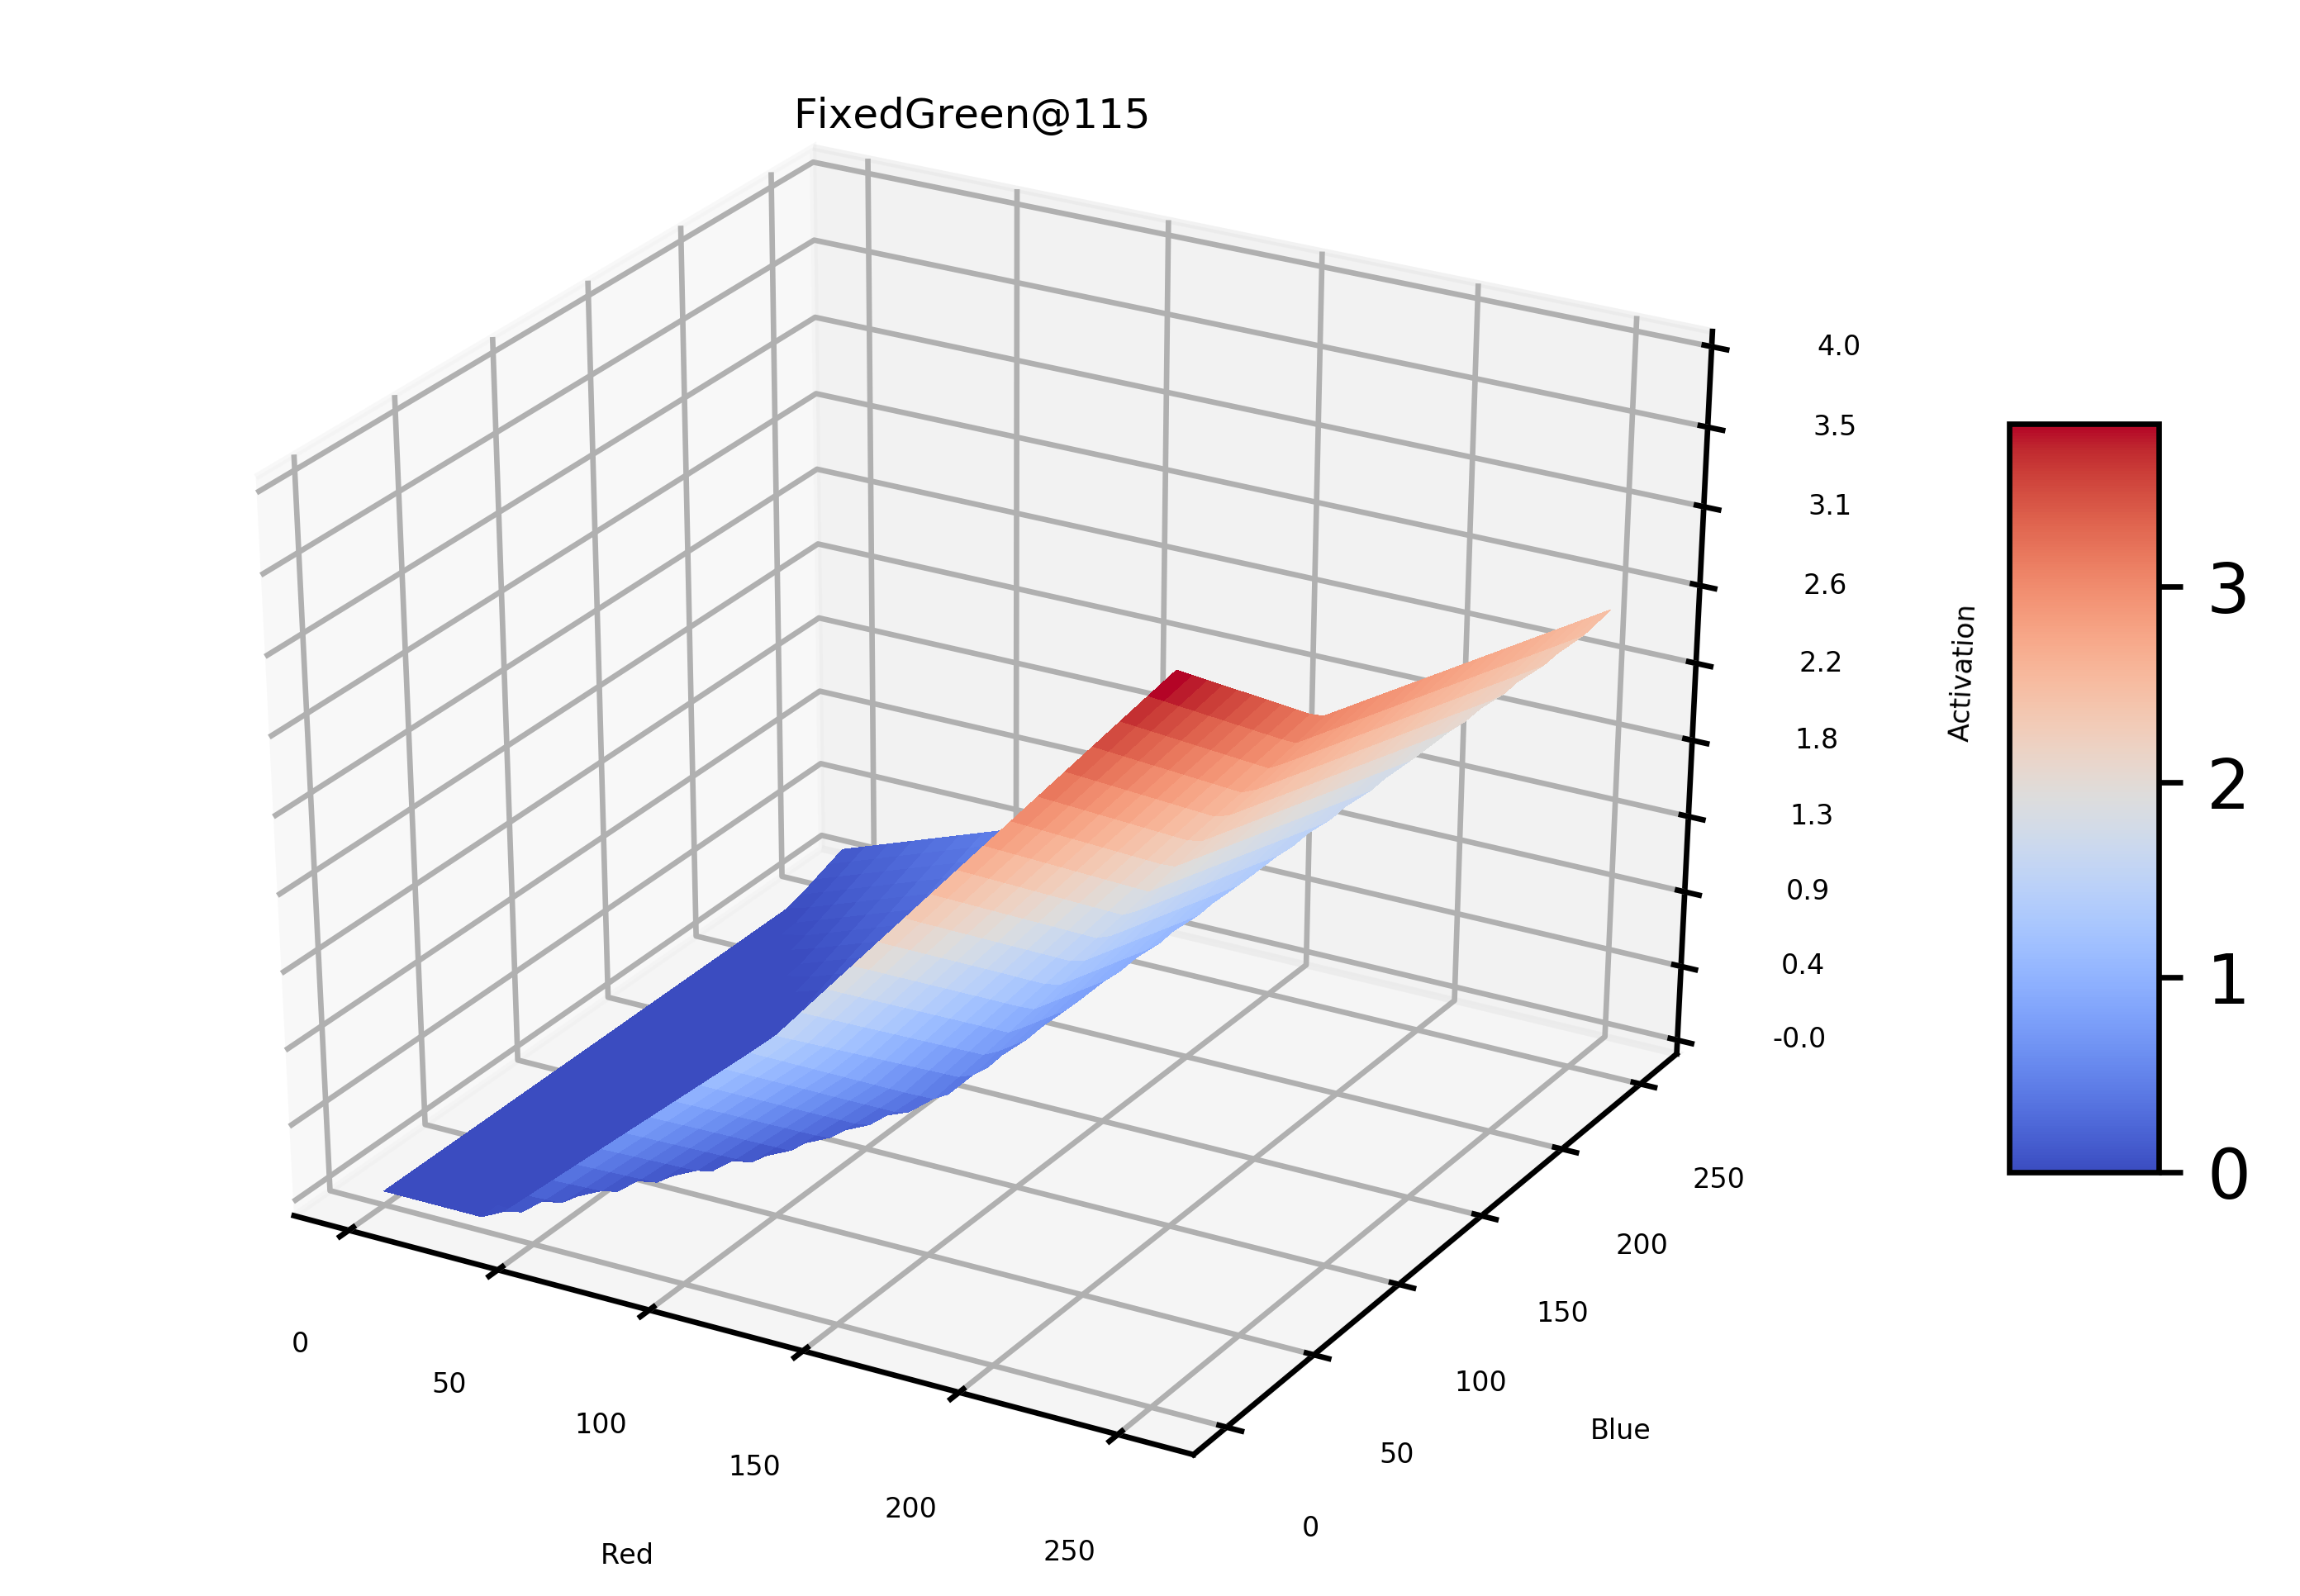

In [11]:
# Fixed Green
plot3DFigure(X=Rp_FixedG, Y=Bp_FixedG, Z=activation_FixedG, fixWho="Green",
             cmap=cm.coolwarm, title="FixedGreen@115")

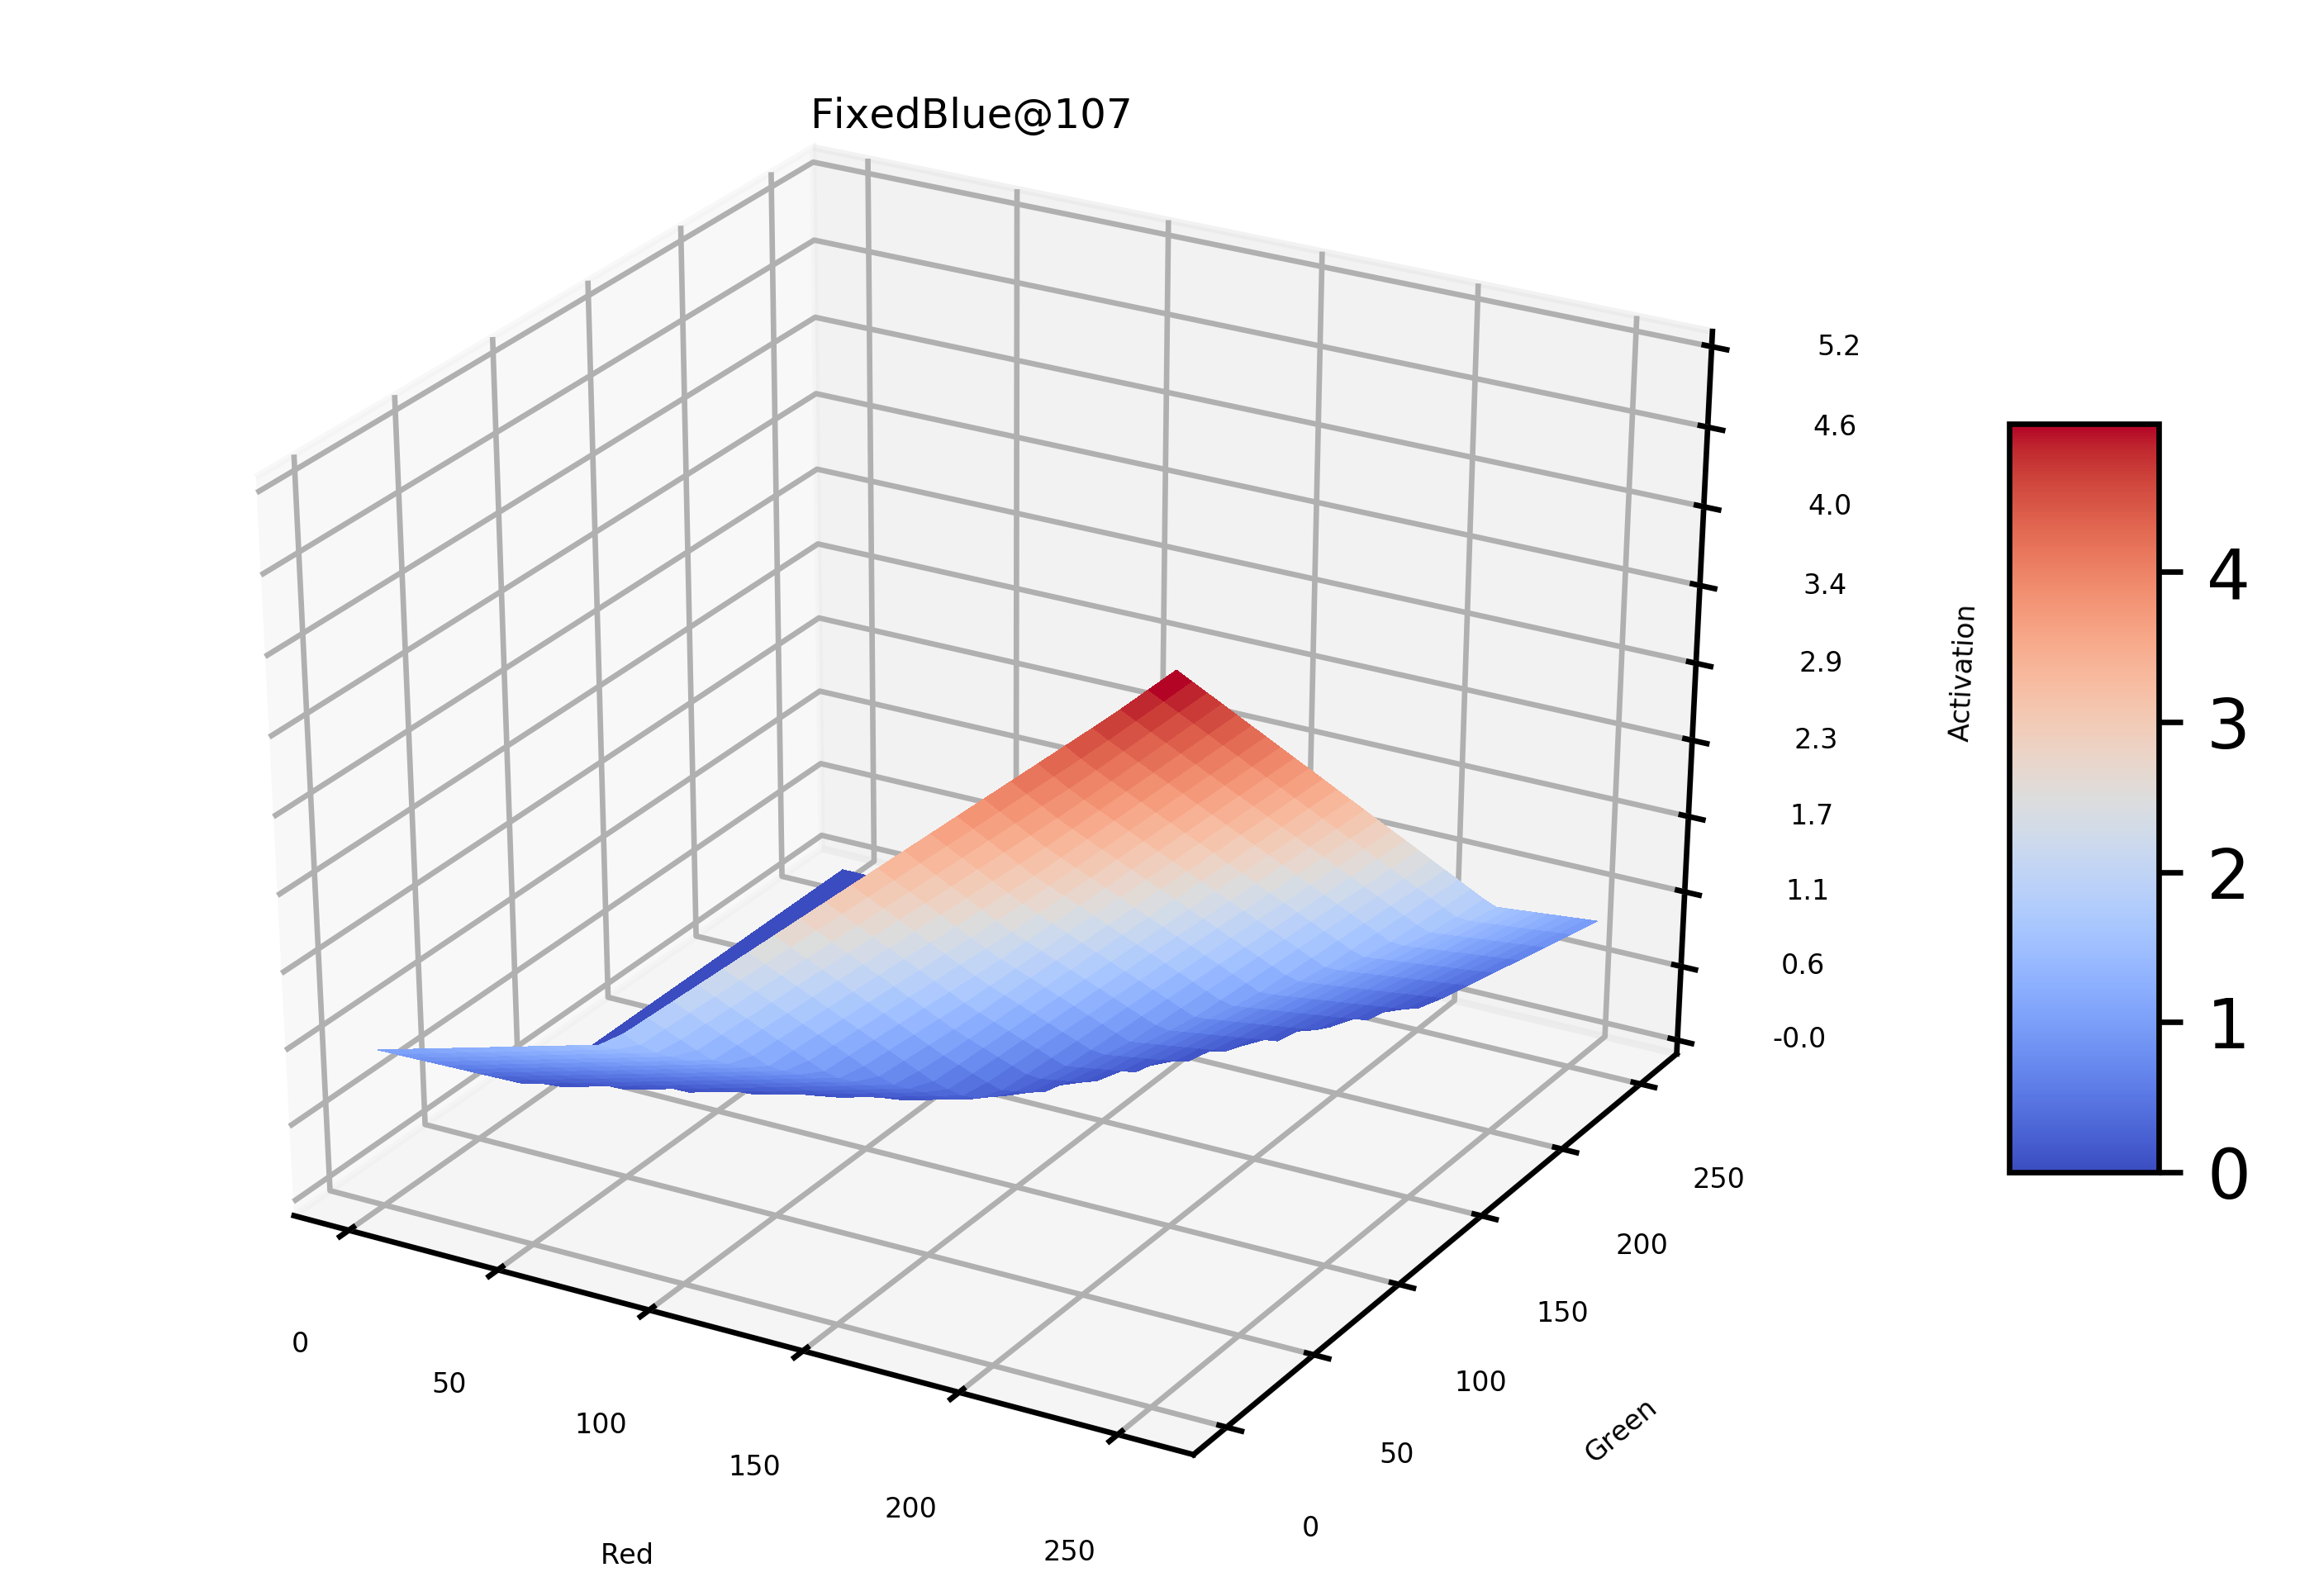

In [12]:
# Fixed Blue
plot3DFigure(X=Rp_FixedB, Y=Gp_FixedB, Z=activation_FixedB, fixWho="Blue",
             cmap=cm.coolwarm, title="FixedBlue@107")